In [ ]:
%load_ext nb_black

In [272]:
import re
import nltk
import spacy
import string
import pyspark
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sqlalchemy import create_engine

from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Flatten, Embedding, concatenate, Conv1D, MaxPooling1D, SimpleRNN

warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

In [2]:
!python -m spacy download en
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✘ Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\c\anaconda3\envs\deeplearning\lib\site-packages\en_core_web_sm -->
C:\Users\c\anaconda3\envs\deeplearning\lib\site-packages\spacy\data\en
⚠ Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')
You do not have sufficient privilege to perform this operation.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordn

True

<IPython.core.display.Javascript object>

In [3]:
nlp = spacy.load("en_core_web_sm")

<IPython.core.display.Javascript object>

# I. Exploratory Data Analysis

For this project, I made my own Docker Containers inside a single Compose that houses both the PostgreSQL database and scraper that I will be using as part of the original roadmap this project has.

For now, I will only be accessing the PostgreSQL database inside a Docker Container since I inserted all my data into it.

In [4]:
# Connecting to the Postgres Server inside a Docker Container
postgres_user = 'forecaster'
postgres_pw = 'forecaster'
postgres_host = '127.0.0.1'
postgres_port = '5435'
postgres_db = 'spx_forecaster'

engine = create_engine(
    f'postgresql://{postgres_user}:{postgres_pw}@{postgres_host}:{postgres_port}/{postgres_db}',
    connect_args={
        'sslmode' : 'disable',
        'gssencmode' : 'disable'
        }
    )

data = pd.read_sql_query('select * from news_stock', con=engine)

engine.dispose()

<IPython.core.display.Javascript object>

## i. News Data

I have two sources. Most of the news data ranging from 2008 to 2016 were pulled from **https://www.kaggle.com/aaron7sun/stocknews** since it was readily-available over at Kaggle. The rest are news I crawled from four sources' news list for SPX:
* FXEmpire.com
* DailyFX.com
* CNBC
* Investing.com

Let's have a look at what they have and how well can these datasets predict whether the SPX's indexed price will go up or down based on the headlines alone.

Legend:
* 2  - Value rose
* 1  - Value stayed the same
* 0 - Value decreased

In [5]:
print(f'News + Stock Data Shape: {data.shape}')

News + Stock Data Shape: (3113, 10)


<IPython.core.display.Javascript object>

In [6]:
data = data.astype({'label' : 'int8'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3113 non-null   datetime64[ns]
 1   headline   3113 non-null   object        
 2   open       3113 non-null   float64       
 3   high       3113 non-null   float64       
 4   low        3113 non-null   float64       
 5   close      3113 non-null   float64       
 6   adj_close  3113 non-null   float64       
 7   volume     3113 non-null   float64       
 8   diff       3113 non-null   float64       
 9   label      3113 non-null   int8          
dtypes: datetime64[ns](1), float64(7), int8(1), object(1)
memory usage: 222.0+ KB


<IPython.core.display.Javascript object>

In [7]:
data.isna().mean() # checking for missing data

date         0.0
headline     0.0
open         0.0
high         0.0
low          0.0
close        0.0
adj_close    0.0
volume       0.0
diff         0.0
label        0.0
dtype: float64

<IPython.core.display.Javascript object>

I contemplated of whether to use Spark or Dask despite the relatively small dataset that I have. Either way, I would possibly be able to achieve my goal of putting an NLP and Time Series model in an ensemble.

For this project, I went ahead and used SKLearn for classification tasks. PySpark kept on putting my system in an eternal loop I cannot troubleshoot.

### a. Scope and Data Cleaning

Setting the scope was a challenge since I did not have the time to use a Hugging Face Transformer for a more reliable sentiment analysis over the headline data that I was able to collect. Despite having a unique set of headlines 3,113 dates, it is time-consuming to determine at this point by how much headlines there are in this dataset.

Since there are virtually no null values, I can go straight to doing text preprocessing.

In [8]:
def preprocess_stemmed(doc):
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    preprocessed = []

    tokenized = word_tokenize(doc)
    cleaned = [stemmer.stem(lemmatizer.lemmatize(token.lower()))
    for token in tokenized
    if not token.lower() in stopwords.words("english")
    if token.isalpha()]

    untokenized = " ".join(cleaned)
    preprocessed.append(untokenized)

    return preprocessed

def generate_wordcloud(text, colormap='tab10', background_color='white'):
    cloud = WordCloud(width=1600, height=900,
                      stopwords=STOPWORDS,
                      colormap=colormap,
                      background_color=background_color).generate(text)

    plt.figure(figsize=(15,12))
    plt.imshow(cloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# grabbed this function set from my COVID-19 Sentiment Analysis project; forgive the regex I left in. I'm meaning to actually crawl Twitter data too in the near future.
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)

<IPython.core.display.Javascript object>

In [9]:
pos = data.loc[data['label'] == 2]
ntr = data.loc[data['label'] == 1]
neg = data.loc[data['label'] == 0]

<IPython.core.display.Javascript object>

In [10]:
print(f'Positive: {pos.shape}\nNeutral: {ntr.shape}\nNegative: {neg.shape}')

Positive: (1700, 10)
Neutral: (2, 10)
Negative: (1411, 10)


<IPython.core.display.Javascript object>

Before showing the text statistics, here are wordclouds of the three different labels.

In [11]:
pos_text = ' '.join(pos.headline)
ntr_text = ' '.join(ntr.headline)
neg_text = ' '.join(neg.headline)

<IPython.core.display.Javascript object>

### b. Word Clouds

### 1) Label 2 - Value rose

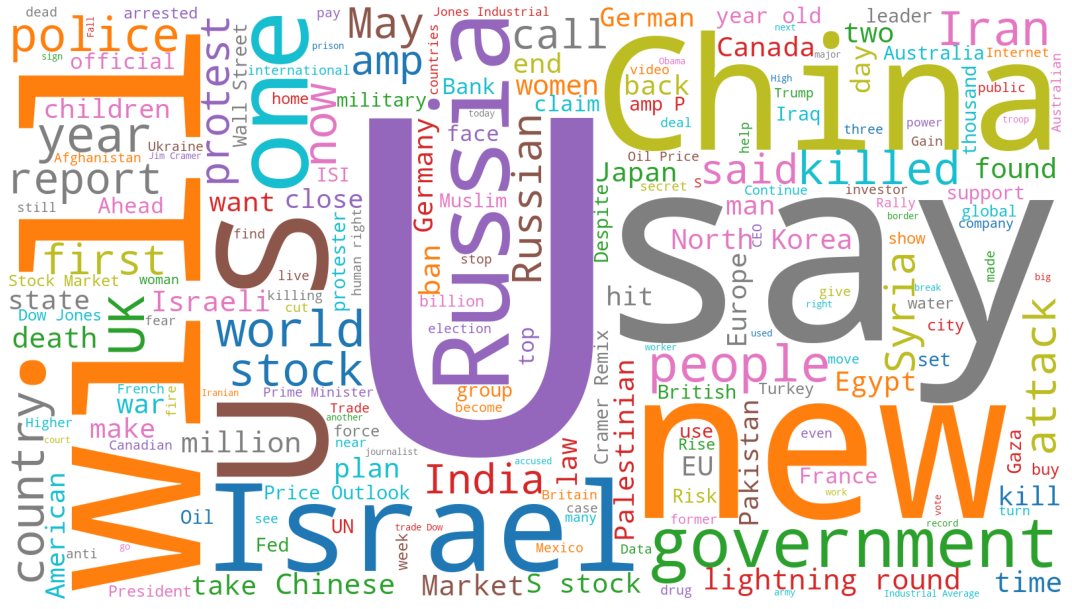

<IPython.core.display.Javascript object>

In [12]:
generate_wordcloud(pos_text)

### 2) Label 1 - No change in value

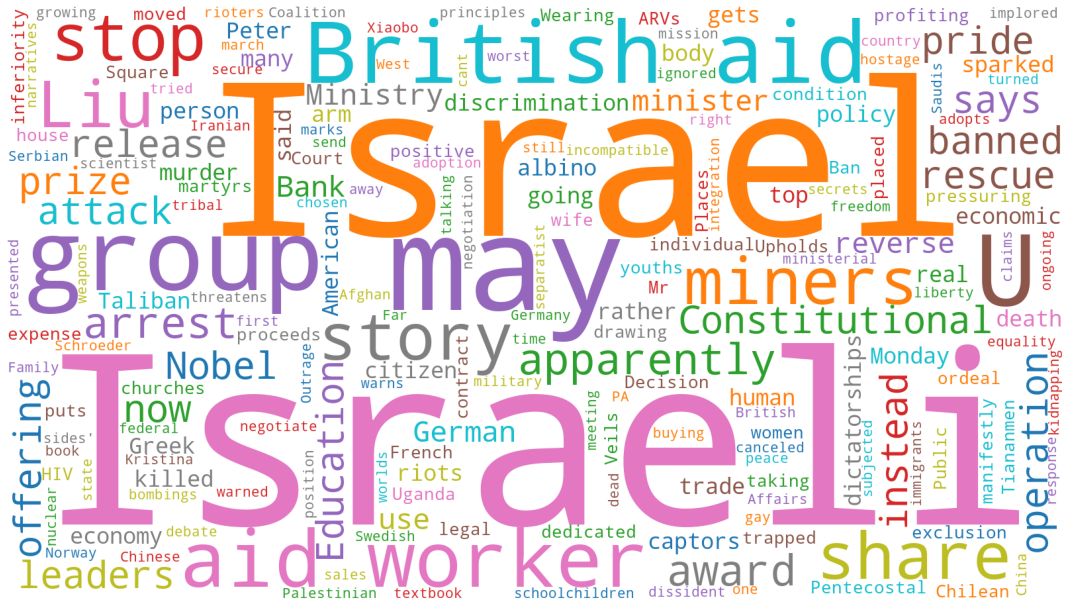

<IPython.core.display.Javascript object>

In [13]:
generate_wordcloud(ntr_text)

### 3) Label 0 - Value decreased

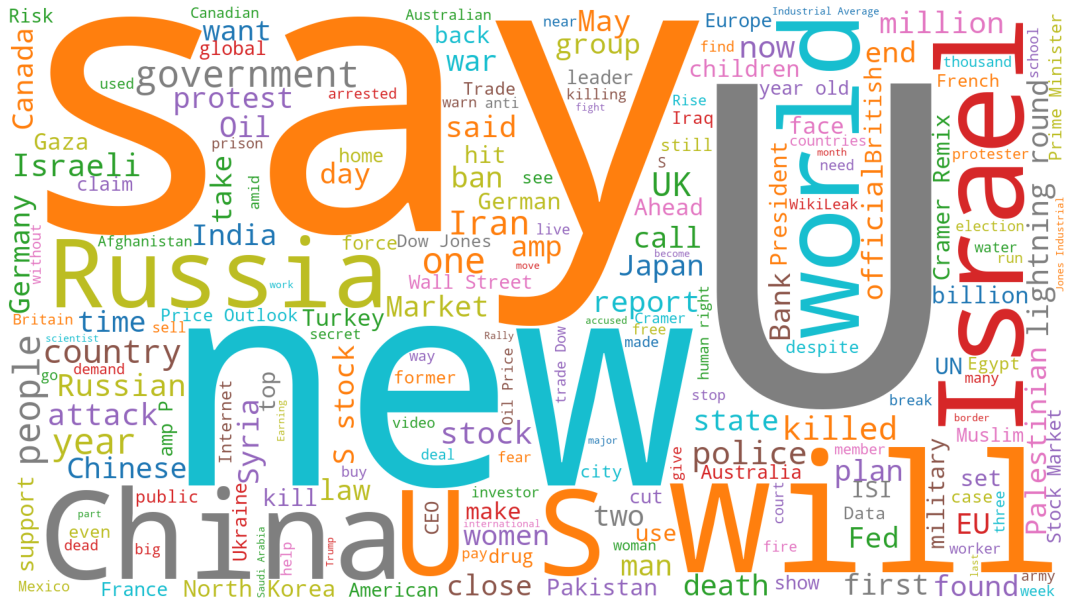

<IPython.core.display.Javascript object>

In [14]:
generate_wordcloud(neg_text)

As it stands, the wordclouds are fairly unreliable when it comes to keywords that determine whether the price index of S&P 500 would rise or.
However, this will not be enough to determine how well it would do if I were to run a multiclass regression model with this data.

In [15]:
headlines = ' '.join(data.headline) # combining all text into one string

<IPython.core.display.Javascript object>

In [16]:
cleaned = [
           token.lower() for token in word_tokenize(headlines)
           if token.lower() not in stopwords.words("english")
           if token.isalpha()]

fdist = FreqDist(cleaned)

<IPython.core.display.Javascript object>

In [17]:
fdist_df = pd.DataFrame.from_dict(fdist, orient="index").reset_index()
fdist_df.columns = ["Term", "Freq"]
ordered_fdist = fdist_df.sort_values("Freq", ascending=False)
ordered_fdist

Term  Freq
122               us  4280
35              says  3009
140              new  2794
103            china  2581
4130          stocks  2497
...              ...   ...
26380     croissants     1
26379         asiana     1
26378        quantas     1
26376  contravention     1
43742       indexdow     1

[43743 rows x 2 columns]

<IPython.core.display.Javascript object>

### Term Distribution Frequency

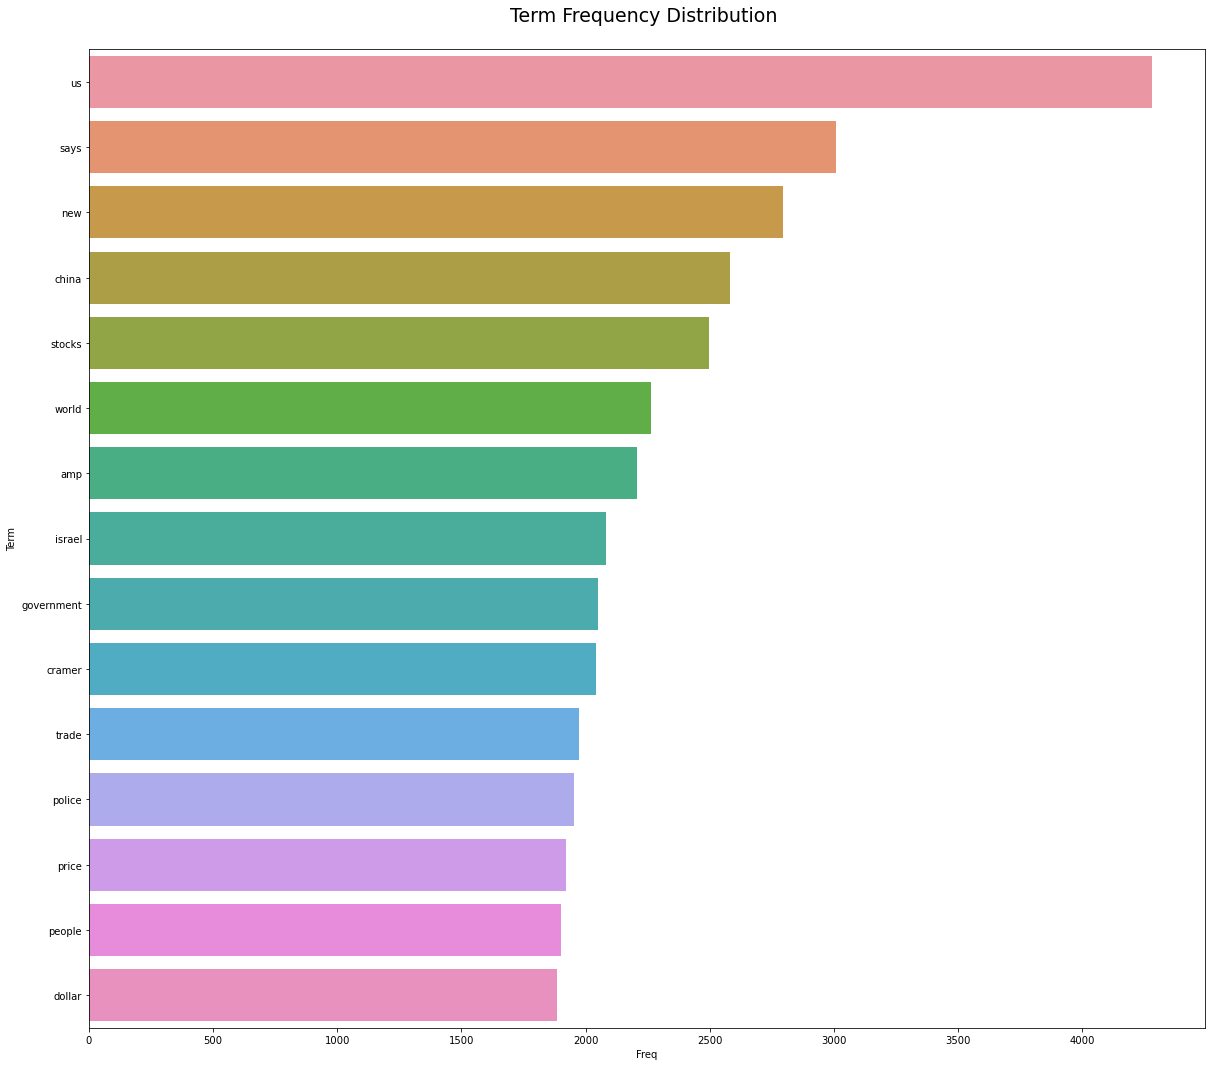

<IPython.core.display.Javascript object>

In [19]:
plt.figure(figsize=(20,18))
sns.barplot(data=ordered_fdist.head(15), x="Freq", y="Term")
plt.title("Term Frequency Distribution \n", fontsize=19)
plt.show()

As it seems, the top term is apparently "US" with some mentions of other countries and related keywords to stock prices. Again, this is all speculatory at this point - it is hard to estimate how well these distributions will fare later in modeling.

In [20]:
# Determine vocabulary size with some statistics
sents = sent_tokenize(headlines)
words = word_tokenize(headlines)
avg_words_sent = sum([len(sent) for sent in sents])/ len(sents)
vocab = len(set([word.lower() for word in words]))
print(f'Number of sentences: {len(sents)}')
print(f'Vocabulary: {vocab}')
print(f'Lexical Diversity: {vocab/len(words)}')

Number of sentences: 25143
Vocabulary: 59497
Lexical Diversity: 0.048638264303027576


<IPython.core.display.Javascript object>

### c. Pipelining for NLP Analysis with Random Forest Classifier

In [21]:
X = data.headline
y = data.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<IPython.core.display.Javascript object>

In [22]:
# Setting up Pipelines
clf_model = Pipeline(
    [
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression(n_jobs=-1))
    ], verbose=1)

clf_model.fit(X_train, y_train)

rf_model = Pipeline(
    [
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('rf', RandomForestClassifier(n_jobs=-1))
    ], verbose=1)

rf_model.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.6s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.5s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ................ (step 3 of 3) Processing rf, total=   0.3s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('rf', RandomForestClassifier(n_jobs=-1))],
         verbose=1)

<IPython.core.display.Javascript object>

In [23]:
clf_test = clf_model.score(X_test, y_test)
rf_test = rf_model.score(X_test, y_test)

print(f"Logistic Regression Test Score: {clf_test}\nRandom Forest Classifier Test Score: {rf_test}")

Logistic Regression Test Score: 0.5682182985553772
Random Forest Classifier Test Score: 0.5409309791332263


<IPython.core.display.Javascript object>

Logistic Regression has a higher test score than the Random Forest Classifier.

In [24]:
clf_pred = clf_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

<IPython.core.display.Javascript object>

In [25]:
print(classification_report(y_test, clf_pred))

              precision    recall  f1-score   support

           0       0.52      0.34      0.41       276
           2       0.59      0.75      0.66       347

    accuracy                           0.57       623
   macro avg       0.55      0.54      0.54       623
weighted avg       0.56      0.57      0.55       623



<IPython.core.display.Javascript object>

In [26]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.47      0.25      0.33       276
           2       0.56      0.77      0.65       347

    accuracy                           0.54       623
   macro avg       0.52      0.51      0.49       623
weighted avg       0.52      0.54      0.51       623



<IPython.core.display.Javascript object>

Since there were only two actual 1's (no change in value), a class imbalance was unavoidable. In a way, I could just lump those two results together with the 2's (value rose). Either way - these results are not promising by themselves. But as seen in the recall score for 2's, it seems as though uptrends are easier to figure out for the models.

## ii. Stock Data

I initially aimed for gathering all the individual S&P 500 indices but since Spark was just not working at all on my computer, I had to drop the idea and focus on the entirety of the index instead.

The idea here after EDA would be to present how I can use LSTM to predict prices with regards to historic data.

### a. Change in Price over Time

In [27]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

<IPython.core.display.Javascript object>

In [28]:
stock = data.drop(columns=['headline', 'label'])
stock.head()

date     open     high      low    close  adj_close        volume  \
0 2008-08-08  1266.29  1297.85  1262.11  1296.32    1296.32  4.966810e+09   
1 2008-08-11  1294.42  1313.15  1291.41  1305.32    1305.32  5.067310e+09   
2 2008-08-12  1304.79  1304.79  1285.64  1289.59    1289.59  4.711290e+09   
3 2008-08-13  1288.64  1294.03  1274.86  1285.83    1285.83  4.787600e+09   
4 2008-08-14  1282.11  1300.11  1276.84  1292.93    1292.93  4.064000e+09   

        diff  
0  30.029907  
1  10.899902  
2 -15.200073  
3  -2.810059  
4  10.820068

<IPython.core.display.Javascript object>

In [29]:
stock.describe()

open         high          low        close    adj_close  \
count  3113.000000  3113.000000  3113.000000  3113.000000  3113.000000   
mean   1955.720633  1966.523736  1943.959939  1956.087504  1956.087504   
std     733.071896   735.314229   730.541740   733.093635   733.093635   
min     679.280000   695.270000   666.790000   676.530000   676.530000   
25%    1305.470000  1312.700000  1295.730000  1305.440000  1305.440000   
50%    1959.890000  1965.290000  1946.270000  1958.120000  1958.120000   
75%    2566.520000  2578.290000  2548.310000  2562.100000  2562.100000   
max    3815.050000  3826.690000  3792.860000  3824.680000  3824.680000   

             volume         diff  
count  3.113000e+03  3113.000000  
mean   4.041259e+09     0.366871  
std    1.165164e+09    19.507153  
min    1.025000e+09  -150.220210  
25%    3.323120e+09    -6.539917  
50%    3.751230e+09     1.120117  
75%    4.476170e+09     9.189941  
max    1.145623e+10   141.030030

<IPython.core.display.Javascript object>

Looking at the *mean* alone on the difference between *adj_close* and *open*, it seems that SPX do not move much at all.

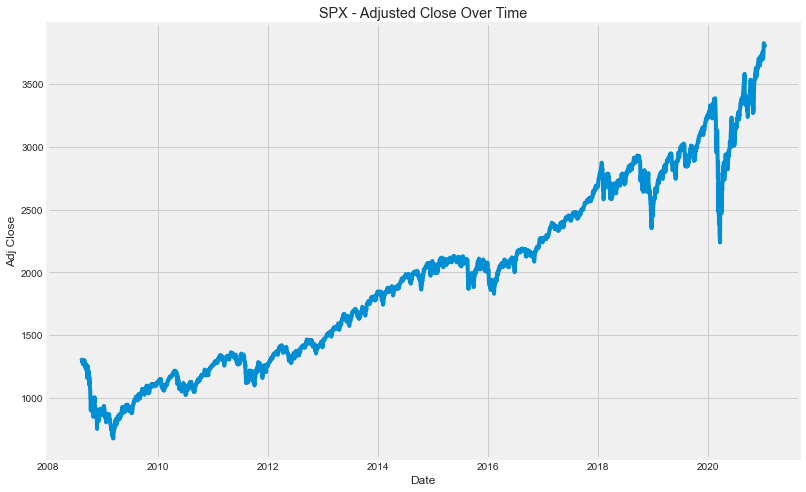

<IPython.core.display.Javascript object>

In [30]:
# Let's see a historical view of the adjusted closing price

plt.figure(figsize=(12, 8))
sns.lineplot(stock.date, stock.adj_close)
plt.ylabel('Adj Close')
plt.xlabel('Date')
plt.title('SPX - Adjusted Close Over Time')
plt.show()

As expected, there was to be a visible dip at the start of COVID restrictions. Also, there seems to be an after-effect of the recession in 2008.

And now, have a look at the daily changes:

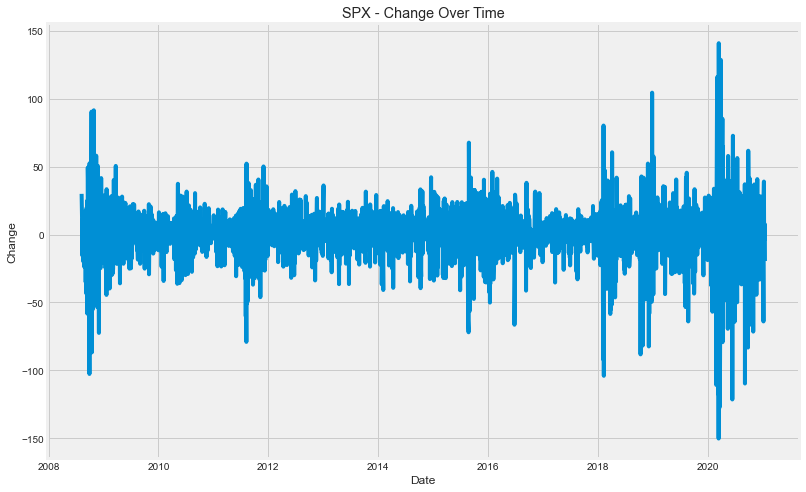

<IPython.core.display.Javascript object>

In [31]:
plt.figure(figsize=(12, 8))
sns.lineplot(stock.date, stock['diff'])
plt.ylabel('Change')
plt.xlabel('Date')
plt.title('SPX - Change Over Time')
plt.show()

### b. Moving Averages

In [32]:
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    stock[col_name] = stock['adj_close'].rolling(ma).mean()

<IPython.core.display.Javascript object>

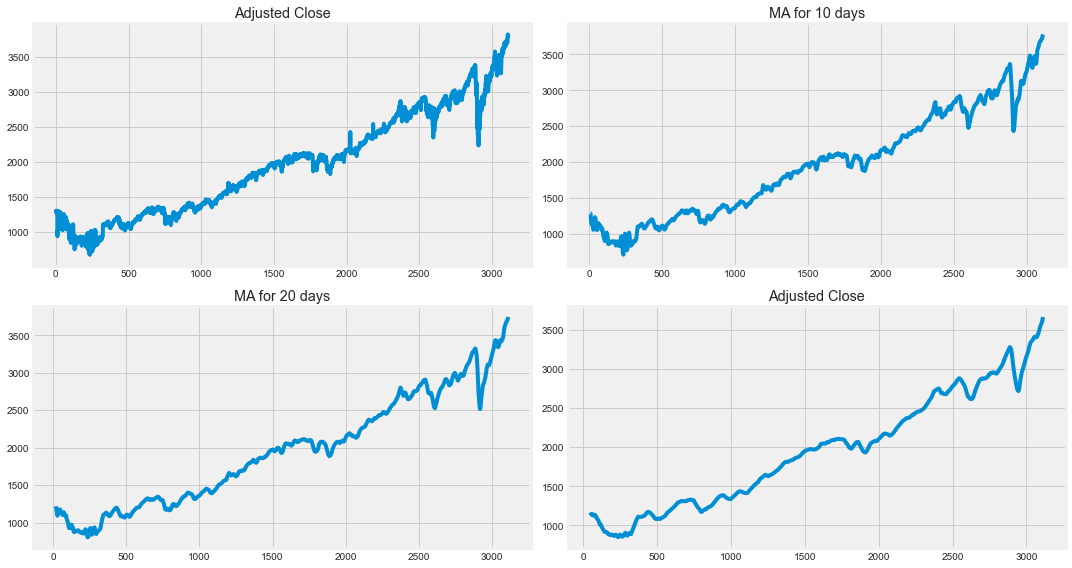

<IPython.core.display.Javascript object>

In [33]:
cols = ['adj_close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

stock['adj_close'].plot(ax=axes[0,0])
axes[0,0].set_title('Adjusted Close')

stock['MA for 10 days'].plot(ax=axes[0,1])
axes[0,1].set_title('MA for 10 days')

stock['MA for 20 days'].plot(ax=axes[1,0])
axes[1,0].set_title('MA for 20 days')

stock['MA for 50 days'].plot(ax=axes[1,1])
axes[1,1].set_title('Adjusted Close')

fig.tight_layout()

<AxesSubplot:>

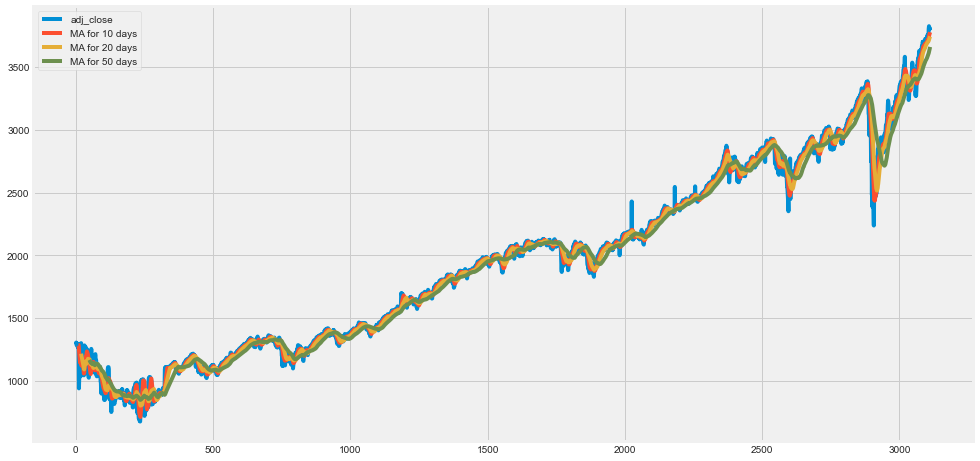

<IPython.core.display.Javascript object>

In [34]:
stock[cols].plot(figsize=(15,8))

### c. Daily Return of SPX on Average

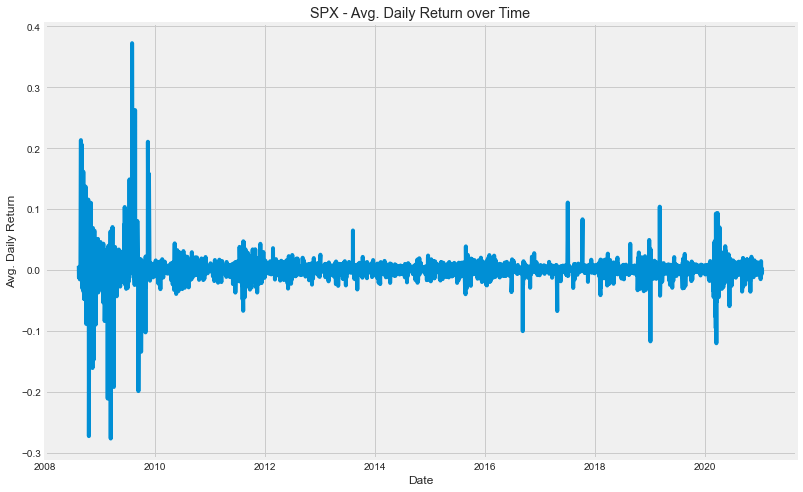

<IPython.core.display.Javascript object>

In [35]:
stock['Daily Return'] = stock['adj_close'].pct_change()

plt.figure(figsize=(12, 8))
sns.lineplot(stock.date, stock['Daily Return'])
plt.ylabel('Avg. Daily Return')
plt.xlabel('Date')
plt.title('SPX - Avg. Daily Return over Time')
plt.show()

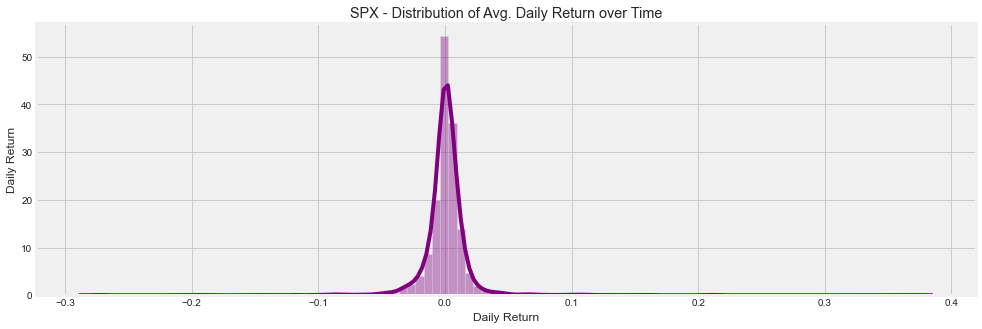

<IPython.core.display.Javascript object>

In [36]:
plt.figure(figsize=(15, 5))
sns.distplot(stock['Daily Return'].dropna(), bins=100, color='purple')
plt.ylabel('Daily Return')
plt.title('SPX - Distribution of Avg. Daily Return over Time')
plt.show()

### d. Value at Risk by investing in SPX

While there are other ways to quantify risk, having the daily percentage returns commpared to the expected returns will always be a good start.

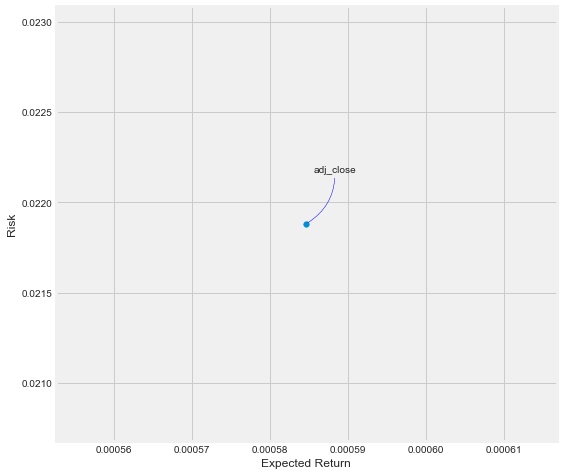

<IPython.core.display.Javascript object>

In [37]:
adj_close = stock[['adj_close']]
tech_rets = adj_close.pct_change()
rets = tech_rets.dropna()

area = np.pi*10

plt.figure(figsize=(8,8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

With SPX being mostly built up of blue chips, the risk is quite low with growth also being low. While recommended for long-term stability, the gain can be lower than some banks' interest rates.

### e. Predicting Closing Prices with LSTM

In [38]:
from sklearn.preprocessing import MinMaxScaler

ndata = stock.filter(['close'])
closing = ndata.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing)

<IPython.core.display.Javascript object>

In [39]:
# Since train-test split is not ideal for this scenario, I will be manually slicing them wrt. 80% of the dataset size
train_len = int(np.ceil(len(closing)*.8))
print(train_len)

2491


<IPython.core.display.Javascript object>

In [40]:
# Creating the training set
train_data = scaled_data[0:int(train_len),:]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

    if i<=61:
        print(f'{X_train}\n{y_train}\n')

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

[array([0.19687435, 0.19973318, 0.19473659, 0.19354224, 0.19579753,
       0.19747153, 0.19124565, 0.18746248, 0.18995601, 0.19096612,
       0.19556565, 0.08386513, 0.10795864, 0.11081429, 0.11334911,
       0.11677017, 0.18751012, 0.18899354, 0.19221765, 0.1982593 ,
       0.11632228, 0.11842193, 0.12459063, 0.12355193, 0.12444452,
       0.12328828, 0.12551181, 0.1220844 , 0.11887934, 0.1168464 ,
       0.12275463, 0.1925893 , 0.19092165, 0.19009577, 0.17797754,
       0.17971825, 0.18781189, 0.17406413, 0.12200181, 0.17645601,
       0.18185919, 0.18270095, 0.16395979, 0.17059861, 0.15242603,
       0.12088052, 0.11223099, 0.11075711, 0.11560123, 0.12013087,
       0.12103934, 0.12354875, 0.12545781, 0.12695075, 0.12599781,
       0.16834649, 0.1837746 , 0.16853072, 0.16253673, 0.16179026])]
[0.1319790988358242]

[array([0.19687435, 0.19973318, 0.19473659, 0.19354224, 0.19579753,
       0.19747153, 0.19124565, 0.18746248, 0.18995601, 0.19096612,
       0.19556565, 0.08386513, 0.107

<IPython.core.display.Javascript object>

Now that the training set is ready for the LSTM model, let's build the model first.

In [42]:
# LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [43]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

2431/2431 [==============================] - 27s 10ms/step - loss: 0.0015 - accuracy: 3.3711e-04


<IPython.core.display.Javascript object>

In [44]:
test_data = scaled_data[train_len-60:,:]

X_test = []
y_test = closing[train_len:,:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

stock_preds = model.predict(X_test)
stock_preds = scaler.inverse_transform(stock_preds)

# Checking RMSE as a metric
rmse = np.sqrt(np.mean(((stock_preds - y_test)**2)))
print(f'Test Root Mean Squared Error: {rmse}')

Test Root Mean Squared Error: 119.27163767121675


<IPython.core.display.Javascript object>

With the LSTM model above, the RMSE for this split is not looking good. Some tweaks are needed to make the model filter substantially. Initially, *batch_size* and *epochs* are set at 1 only to see how this LSTM model would perform. But hopefully, augmenting this with the ANN for sentiment analysis would make it fare better later on. Nonetheless, here is the plot for the data with the predictions:

In [46]:
train

date     open     high      low    close  adj_close        volume  \
0    2008-08-08  1266.29  1297.85  1262.11  1296.32    1296.32  4.966810e+09   
1    2008-08-11  1294.42  1313.15  1291.41  1305.32    1305.32  5.067310e+09   
2    2008-08-12  1304.79  1304.79  1285.64  1289.59    1289.59  4.711290e+09   
3    2008-08-13  1288.64  1294.03  1274.86  1285.83    1285.83  4.787600e+09   
4    2008-08-14  1282.11  1300.11  1276.84  1292.93    1292.93  4.064000e+09   
...         ...      ...      ...      ...      ...        ...           ...   
2486 2018-07-13  2796.93  2804.53  2791.69  2801.31    2801.31  2.614000e+09   
2487 2018-07-16  2797.36  2801.19  2793.39  2798.43    2798.43  2.812230e+09   
2488 2018-07-17  2789.34  2814.19  2789.24  2809.55    2809.55  3.050730e+09   
2489 2018-07-18  2811.35  2816.76  2805.89  2815.62    2815.62  3.089780e+09   
2490 2018-07-19  2809.37  2812.05  2799.77  2804.49    2804.49  3.266700e+09   

           diff  MA for 10 days  MA for 20 days  MA for 50 days  Daily Return  
0     30.029907             NaN             NaN             NaN           NaN  
1     10.899902             NaN             NaN             NaN      0.006943  
2    -15.200073             NaN             NaN             NaN     -0.012051  
3     -2.810059             NaN             NaN             NaN     -0.002916  
4     10.820068             NaN             NaN             NaN      0.005522  
...         ...             ...             ...             ...           ...  
2486   4.380127        2778.017       2758.5625       2741.0196      0.001079  
2487   1.069824        2786.538       2759.7965       2743.1910     -0.001028  
2488  20.209960        2793.832       2762.1445       2746.7874      0.003974  
2489   4.270020        2799.412       2764.5595       2749.8314      0.002160  
2490  -4.880127        2801.444       2767.2960       2752.4686     -0.003953  

[2491 rows x 12 columns]

<IPython.core.display.Javascript object>

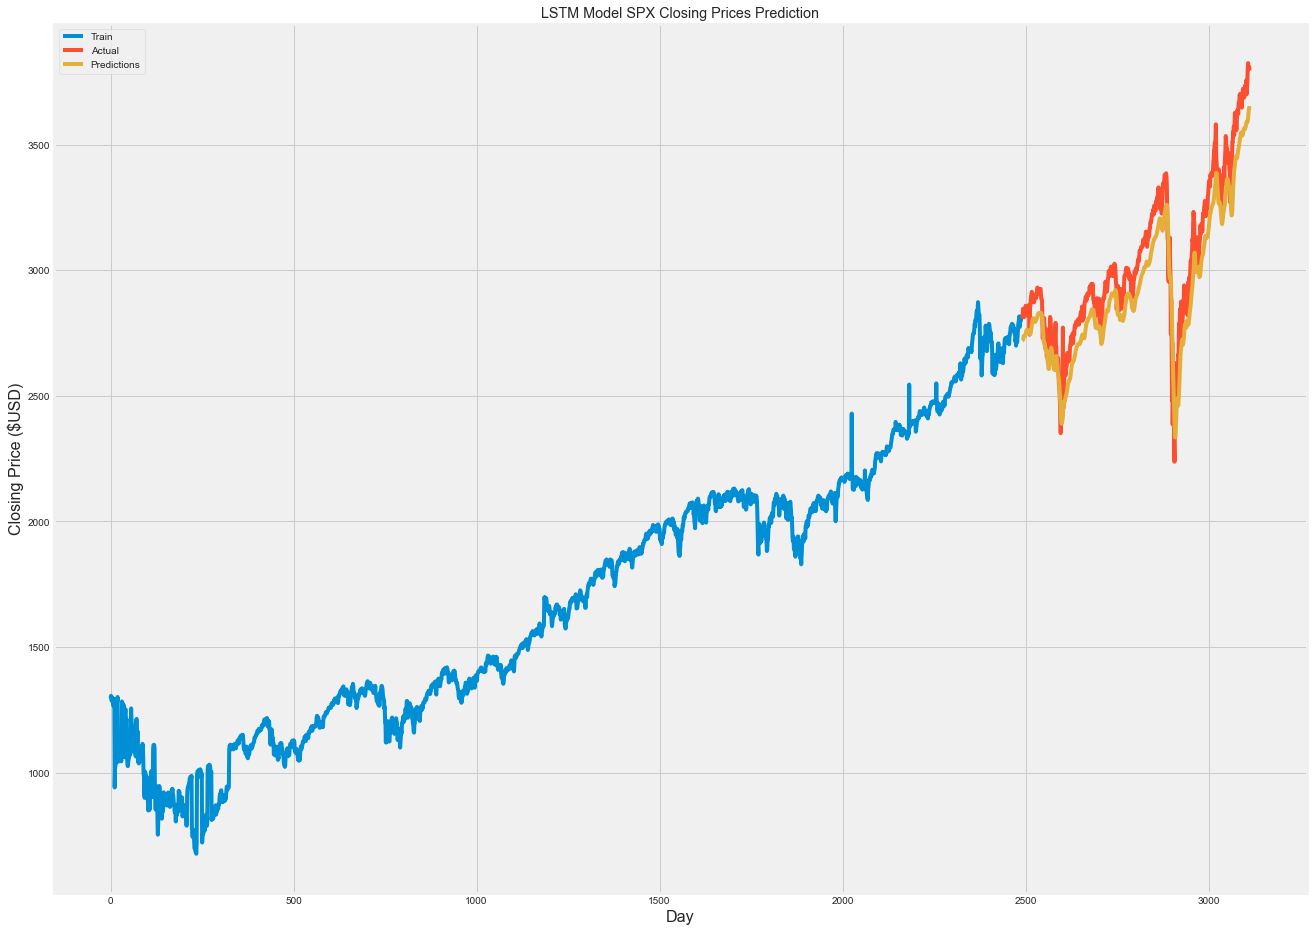

<IPython.core.display.Javascript object>

In [58]:
train = stock[:train_len]
valid = stock[train_len:]
valid['Predictions'] = stock_preds

plt.figure(figsize=(20,16))
plt.title('LSTM Model SPX Closing Prices Prediction')
plt.xlabel('Day', fontsize=16)
plt.ylabel('Closing Price ($USD)', fontsize=16)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='upper left')
plt.show()

Visually, it looks reliable to a point. Going beyond the predicted period will definitely present convergence at some point.

## II. Ensemble Modeling

I will be revising how I processed the news headline data because I need to one hot encode the BoW it will make and pad that before putting it in a branch of the ensemble model below.

In [62]:
stemmer = PorterStemmer()

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)       

def stem_list(word_list):
    stemmed = []
    for word in word_list:
        stemmedword = stemmer.stem(word)
        stemmed.append(stemmedword)
    return stemmed

def normalize(terms):
    terms = terms.lower()
    terms = remove_stopwords(terms)
    word_delimiters = u'[\\[\\]\n.!?,;:\t\\-\\"\\(\\)\\\'\u2019\u2013 ]'
    term_list = re.split(word_delimiters, terms)
    trimmed = [x.rstrip() for x in term_list]
    stemmed = stem_list(trimmed)
    space = ' '
    normed = space.join(stemmed)
    normed = normed.replace('  ', ' ')
    return normed

<IPython.core.display.Javascript object>

The text needs to be normalized properly - that's why I redefined the function set above for EDA for simplicity.

In [64]:
data['normalized'] = data.headline.apply(lambda x: normalize(x))

<IPython.core.display.Javascript object>

In [66]:
# Printing out total unique word count in the headline column
words = []
for doc in data.normalized:
    for word in word_tokenize(doc):
        words.append(word)

unique = set(words)
unique_words = len(unique)
unique_words

37260

<IPython.core.display.Javascript object>

After getting the unique word count, we will now be able to encode the text and pad it properly by 1x1.

In [273]:
encoded_text = [one_hot(doc, unique_words) for doc in data.normalized] # one-hot encoding the headline document per word
ind_vars = pad_sequences(encoded_text) # padding the sequence with a 1x1 pad

scaler = MinMaxScaler()

ndata = stock.filter(['open', 'high', 'low', 'adj_close', 'volume'])
vals = ndata.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(vals)

train_len = int(np.ceil(len(closing)*.8))
print(train_len)

2491


<IPython.core.display.Javascript object>

In [360]:
train_data = scaled_data[0:int(train_len),:]
test_data = scaled_data[int(train_len):,:]

X_st_train = np.array(train_data)
X_st_test = np.array(test_data)

X_hl_train = np.array(ind_vars[0:int(train_len),:])
X_hl_test = np.array(ind_vars[int(train_len):,:])

y_train = np.array(stock['close'][0:int(train_len)])
y_test = np.array(stock['close'][int(train_len):])

<IPython.core.display.Javascript object>

Now, we can freely separate the variables since the padded encoded text was processed separately from the dataframe.

In [377]:
# first branch
# input layer
input_layer_1 = Input(shape=(X_st_train.shape[1],1))
# hidden layers
lstm_1 = LSTM(128, return_sequences=True)(input_layer_1)
lstm_2 = LSTM(64, return_sequences=False)(lstm_1)
path1_1 = Dense(25)(lstm_2)
#path1_2 = Dense(1)(path1_1)

# second branch
# input layer
input_layer_2 = Input(shape=(X_hl_train.shape[1],))
# hidden layers
embedding = Embedding(np.max(X_hl_train) + 1, 100)(input_layer_2)
conv1d_1 = Conv1D(filters=32, kernel_size=8)(embedding)
maxpooling1d_1 = MaxPooling1D(pool_size=2)(conv1d_1)
flatten_1 = Flatten()(maxpooling1d_1)
path2_1 = Dense(32)(flatten_1)
#path2_2 = Dense(1)(path2_1)

# ensemble
merge = concatenate([path1_2, path2_2])
output = Dense(1, activation='relu')(merge)

# model instantiation
model = Model(inputs=[input_layer_1, input_layer_2], outputs=output)
model.summary()

Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_142 (InputLayer)          [(None, 849)]        0                                            
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 849, 100)     3725900     input_142[0][0]                  
__________________________________________________________________________________________________
input_141 (InputLayer)          [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 842, 32)      25632       embedding_57[0][0]               
___________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [379]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(
    x=[X_st_train, X_hl_train], 
    y=y_train,
    epochs=10,
    batch_size=1
    )

Epoch 1/10
2491/2491 [==============================] - 78s 30ms/step - loss: 21942.3058 - accuracy: 0.0000e+00
Epoch 2/10
2491/2491 [==============================] - 77s 31ms/step - loss: 4284.1809 - accuracy: 0.0000e+00
Epoch 3/10
2491/2491 [==============================] - 77s 31ms/step - loss: 2485.7235 - accuracy: 0.0000e+00
Epoch 4/10
2491/2491 [==============================] - 77s 31ms/step - loss: 2380.7238 - accuracy: 0.0000e+00
Epoch 5/10
2491/2491 [==============================] - 77s 31ms/step - loss: 2071.9926 - accuracy: 0.0000e+00
Epoch 6/10
2491/2491 [==============================] - 77s 31ms/step - loss: 2770.4845 - accuracy: 0.0000e+00
Epoch 7/10
2491/2491 [==============================] - 77s 31ms/step - loss: 1368.6610 - accuracy: 0.0000e+00
Epoch 8/10
2491/2491 [==============================] - 77s 31ms/step - loss: 1266.5405 - accuracy: 0.0000e+00
Epoch 9/10
2491/2491 [==============================] - 78s 31ms/step - loss: 1286.3527 - accuracy: 0.0000e+00


<IPython.core.display.Javascript object>

Unfortunately, I cannot get desirable results (at least 50% train accuracy) out of the ensemble model I made. For now, the loss function converges at around 3110890 and the accuracy cannot even break .0001.

Let's see how the test data compares to the predicted data.

In [382]:
stock_preds = model.predict([X_st_test, X_hl_test])

# Checking RMSE as a metric
rmse = np.sqrt(np.mean(((stock_preds - y_test)**2)))
print(f'Test Root Mean Squared Error: {rmse}')

Test Root Mean Squared Error: 427.93893283353697


<IPython.core.display.Javascript object>

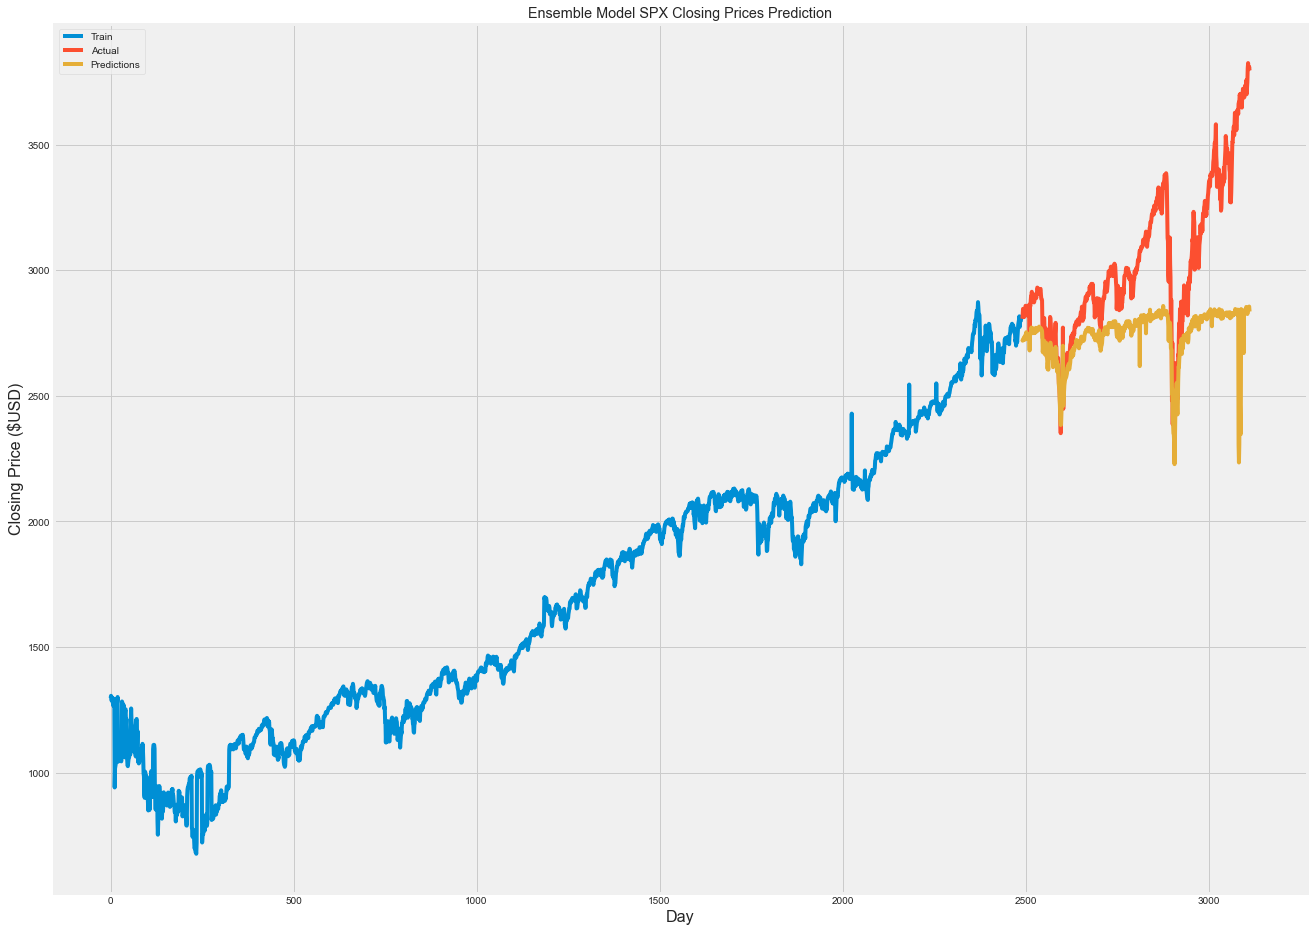

<IPython.core.display.Javascript object>

In [383]:
train = stock[:train_len]
valid = stock[train_len:]
valid['Predictions'] = stock_preds

plt.figure(figsize=(20,16))
plt.title('Ensemble Model SPX Closing Prices Prediction')
plt.xlabel('Day', fontsize=16)
plt.ylabel('Closing Price ($USD)', fontsize=16)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='upper left')
plt.show()

The ensemble model did poor at making predictions better than the LSTM above.

I cannot say for certain at this point what went wrong in the process, but I am sure that it is somewhere in how I instantiated the ensemble. In a way, I should not have combined or merged the text results with stock results directly - which caused a lot of irregularization. Also, I did not add any regularization method because the train accuracy was not going anywhere.

# Future Updates:

- As mentioned in my proposal, I was supposed to used both Dask and Spark for EDA at least but both kept crashing my IDE and PC and I didn't have the time to fix things.
- Streaming data into the database inside a Docker Container was more work than I can handle for now.
- Auto-updates on the prediction graph!
- Also, I want to do more analysis over the possible ratios with the stock data. I just don't understand enough of it yet so I didn't add them yet for this project.